# Vietnamese Emotion Classification using PhoBERT
- Input:
    - Sentence
- Output:


## 1. Import library

In [210]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import csv

from wordcloud import WordCloud
import plotly.express as px
from collections import Counter
from nltk.corpus import stopwords

import torch
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [211]:
stop_words = set(stopwords.words('vietnamese')) 

In [212]:
# Load pre-trained PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base")
encode_lable = LabelEncoder()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Craw Data

In [213]:
def save(name, a):
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    dataset = pd.DataFrame(data=df)
    dataset.to_excel(f'./DataSet/{name}.xlsx', encoding='utf-8-sig')

In [214]:
def get_data(name, dict_url):

    driver = webdriver.Edge("./msedgedriver.exe")

    Contents = []
    Topic = []
    dictionary = {'Content': Contents, 'Topic': Topic}

    for _topic, quantity in dict_url.items():
        driver.get(f'https://vtv.vn/{_topic}.htm')
        content = []
        count = 0
        status = True
        while status:
            items = driver.find_elements(By.XPATH, '/html/body/form/div[2]/div[3]/div[3]/div/div[1]/div[1]/div[3]/div[1]/ul/li')

            for item in items:
                if count >= quantity:
                    status = False
                    break
                # Tìm tiêu đề tin tức
                content.append(item.find_element(By.XPATH,  './/h4/a').text)
                topic = [_topic for _ in range(len(content))]
                count += 1
            # Tìm nút "Xem thêm"
            load_more_button = driver.find_element(By.XPATH, '/html/body/form/div[2]/div[3]/div[3]/div/div[1]/div[1]/div[3]/div[2]/a')

            if not load_more_button.is_displayed():
                break
            load_more_button.click()

            time.sleep(5)
        Topic.extend(topic)
        Contents.extend(content)
    save(name, dictionary)

In [215]:
dict_url_big = {    'chinh-tri':        1856,
                    'xa-hoi':           1005,
                    'kinh-te':          2326,
                    'truyen-hinh':      2164,
                    'cong-nghe':        548,
                    'doi-song':         1456,
                    'van-hoa-giai-tri': 1564
                }

dict_url_small = {  'chinh-tri':        213,
                    'xa-hoi':           113,
                    'kinh-te':          566,
                    'truyen-hinh':      36,
                    'cong-nghe':        156,
                    'doi-song':         102,
                    'van-hoa-giai-tri': 189
                }

# get_data("big_data", dict_url_big)
# get_data("small_data", dict_url_small)

## Load Data

In [216]:
def read_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Content', 'Topic']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

In [217]:
df_small = read_data('D:/Learning/Data_Analytics/Crawl Data/End_term_VN/DataSet/small_data.xlsx')
df_big = read_data('D:/Learning/Data_Analytics/Crawl Data/End_term_VN/DataSet/big_data.xlsx')

In [218]:
df_small.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


In [219]:
df_big.head()

,Content,Topic
0,Thủ tướng Phạm Minh Chính tiếp xúc cử tri trướ...,chinh-tri
1,Thủ tướng bổ nhiệm lại Thứ trưởng Bộ Công Thương,chinh-tri
2,Thủ tướng Phạm Minh Chính dự khai mạc Lễ hội H...,chinh-tri
3,“Không có vướng mắc nào của địa phương không đ...,chinh-tri
4,"Dù ở vị trí nào mà có trách nhiệm, khát khao c...",chinh-tri


## Exploratory data analysis

In [220]:
def plot_topic(df):
    plt.figure(figsize=(20, 10))
    sns.countplot(x='Topic', data=df)
    plt.title("Number of sample")
    plt.show()

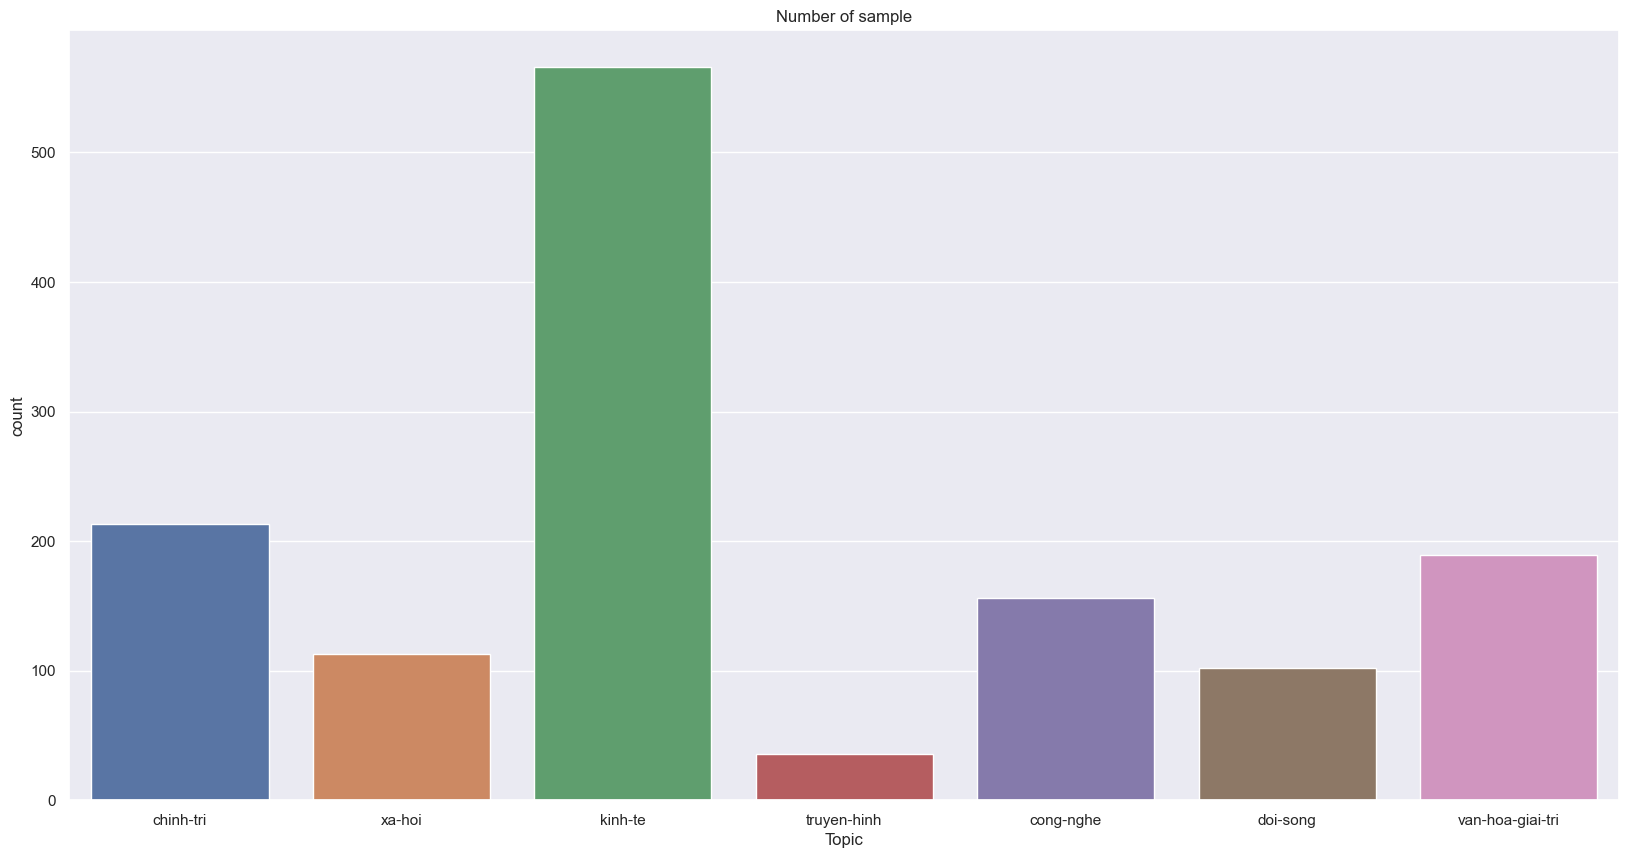

In [221]:
plot_topic(df_small)

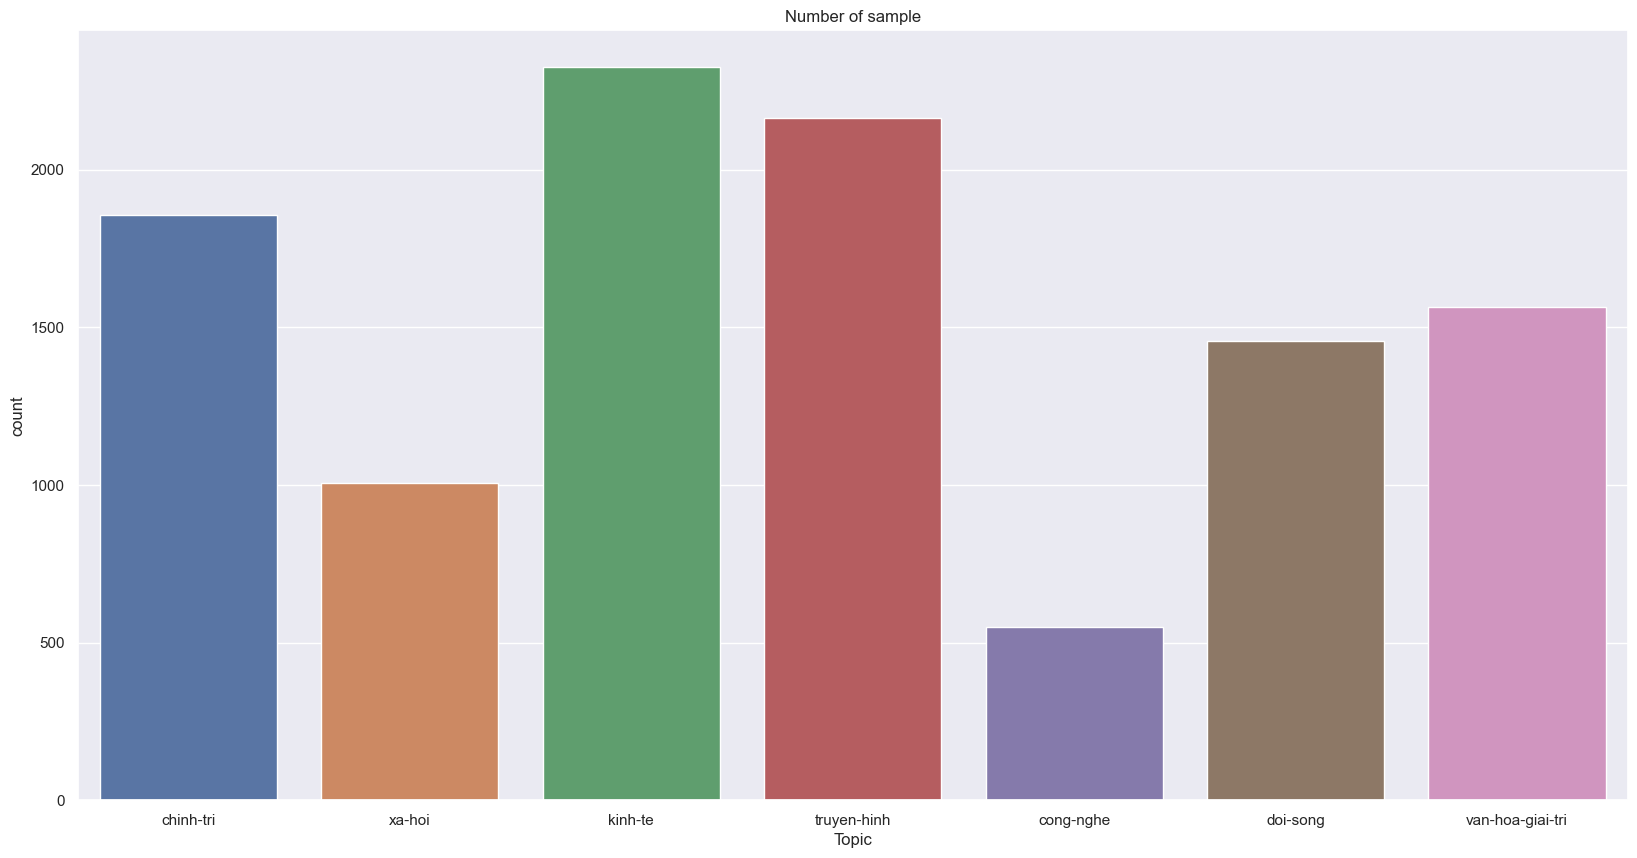

In [222]:
plot_topic(df_big)

In [223]:
df_big['Topic'].value_counts()

kinh-te             2326
truyen-hinh         2164
chinh-tri           1856
van-hoa-giai-tri    1564
doi-song            1456
xa-hoi              1005
cong-nghe            548
Name: Topic, dtype: int64

In [224]:
df_small['Topic'].value_counts()

kinh-te             566
chinh-tri           213
van-hoa-giai-tri    189
cong-nghe           156
xa-hoi              113
doi-song            102
truyen-hinh          36
Name: Topic, dtype: int64

In [225]:
def group_topic(topic):
    if topic in ['chinh-tri']:
        return 'chinh-tri'
    elif (topic in ['kinh-te']):
        return 'kinh-te'
    elif (topic in ['cong-nghe']):
        return 'Công-nghệ'
    elif (topic in ['xa-hoi']):
        return 'xa-hoi'
    else: 
        return 'Khác'

In [226]:
df_small['Topic'] = df_small['Topic'].apply(lambda topic: group_topic(topic))
df_big['Topic'] = df_big['Topic'].apply(lambda topic: group_topic(topic))

In [227]:
df_small['Topic'].value_counts()

kinh-te      566
Khác         327
chinh-tri    213
Công-nghệ    156
xa-hoi       113
Name: Topic, dtype: int64

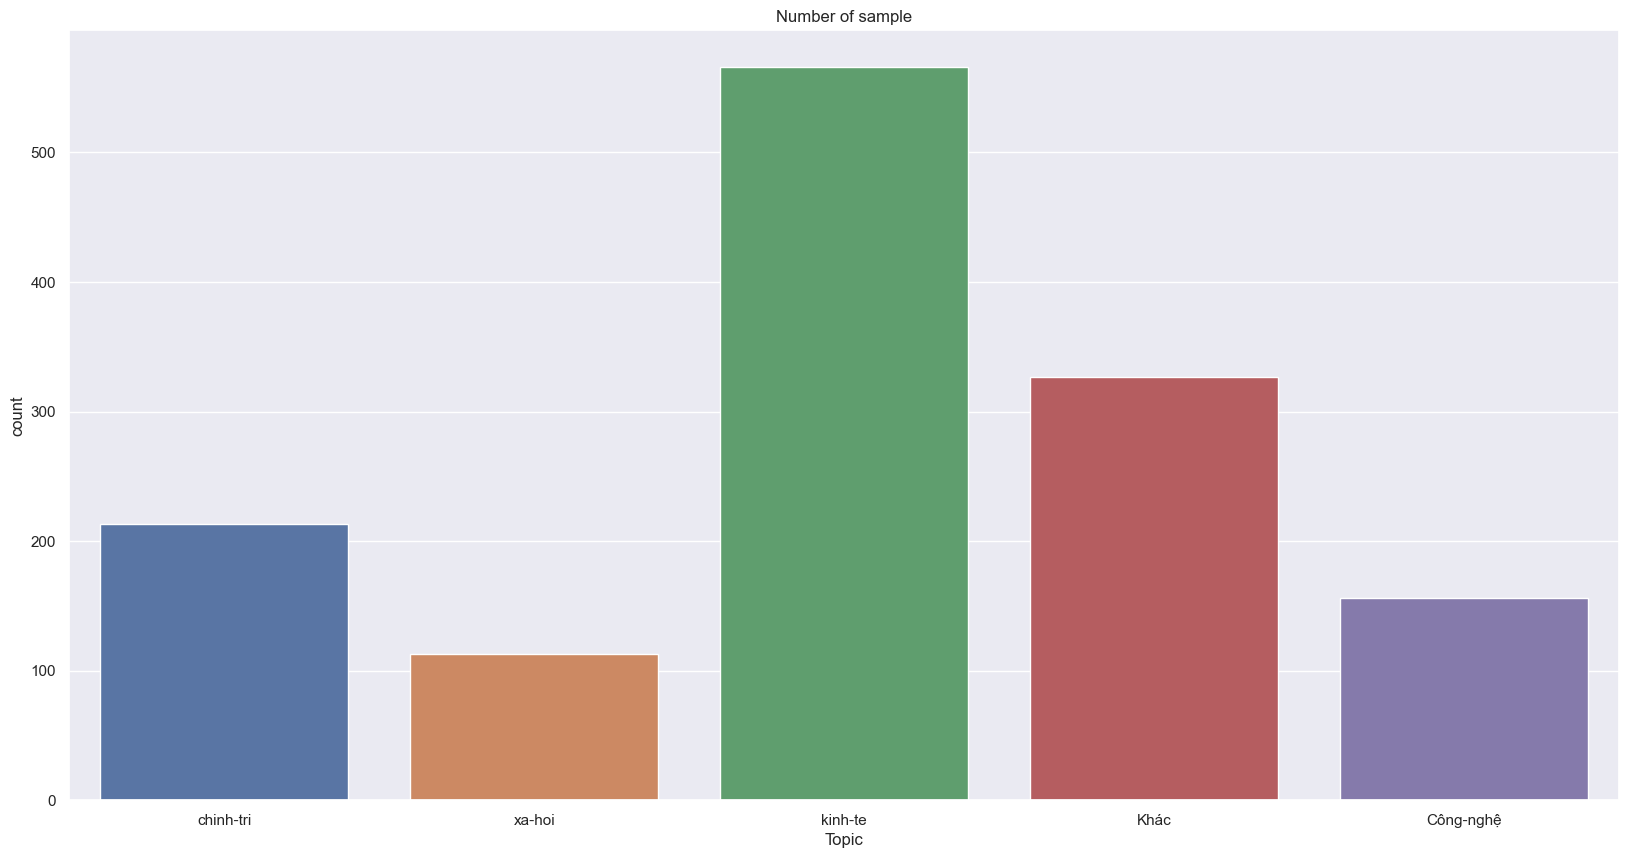

In [228]:
plot_topic(df_small)

In [229]:
df_big['Topic'].value_counts()

Khác         5184
kinh-te      2326
chinh-tri    1856
xa-hoi       1005
Công-nghệ     548
Name: Topic, dtype: int64

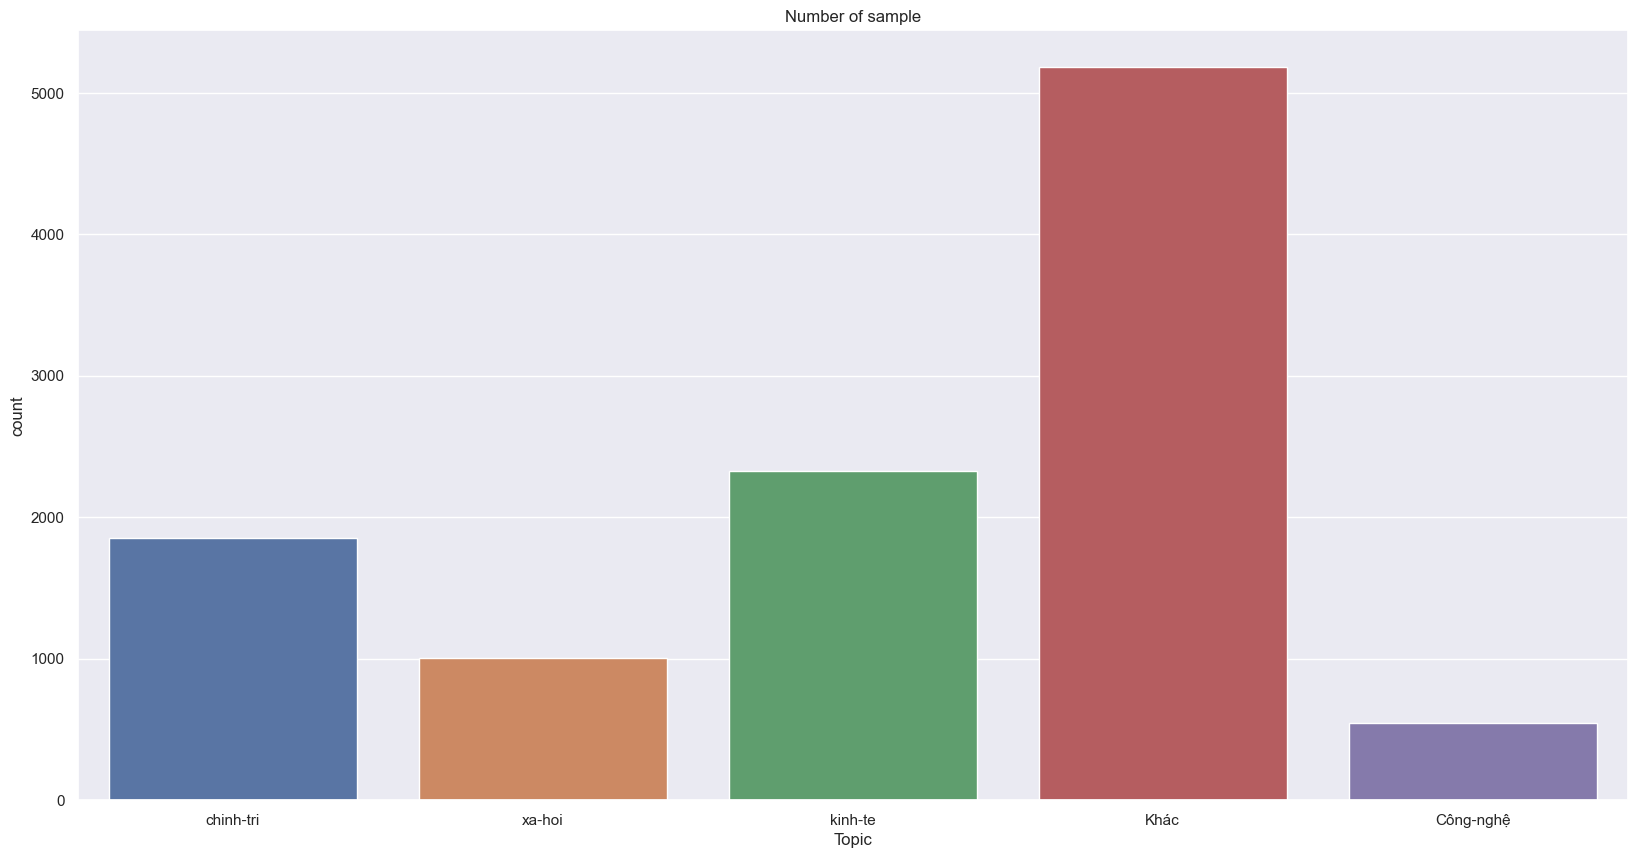

In [230]:
plot_topic(df_big)

In [231]:
def plot_count_token():
    all_data = df_big['Content'].tolist() + df_small['Content'].tolist()
    token_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
    token_lens = [len(text) for text in token_text]

    sns.set(rc={'figure.figsize':(20, 10)})
    sns.displot(token_lens, height=5, aspect=3)
    plt.xlim([0,max(token_lens)])
    plt.xlabel('Token Count')
    plt.show()

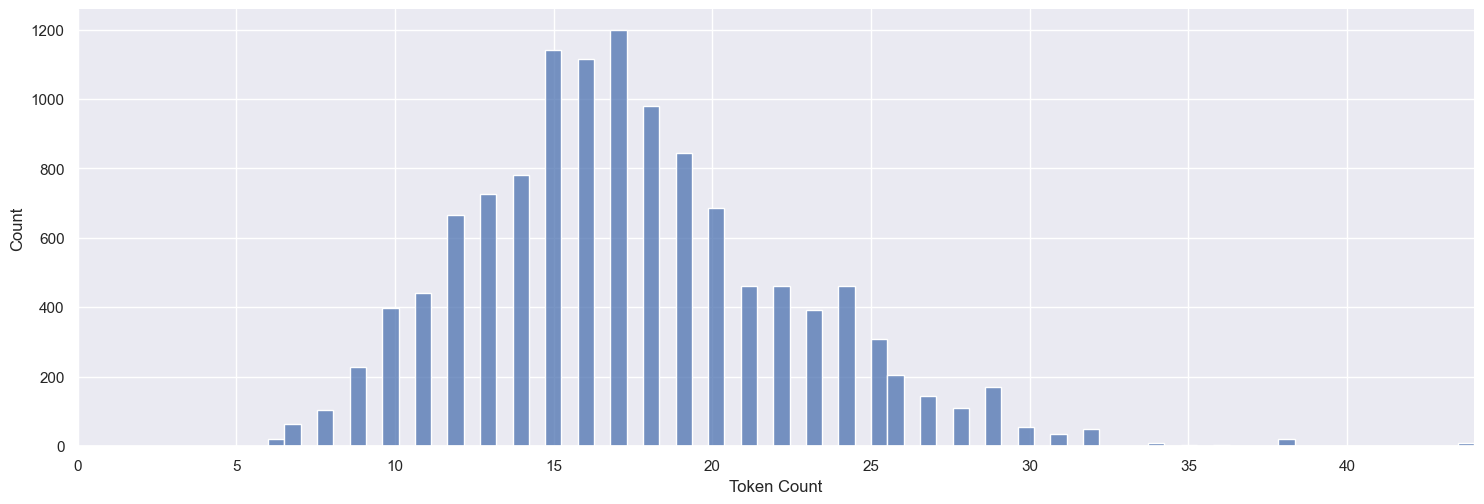

In [232]:
plot_count_token()

In [233]:
def top_word():
    top = Counter([item for sublist in df_big['Content'].apply(lambda x:str(x).split()) for item in sublist])
    print(len(top))
    temp = pd.DataFrame(top.most_common(50))
    temp.columns = ['Common_words','count']
    return temp

In [234]:
top_word = top_word()
top_word.style.background_gradient(cmap='Blues')

3334


,Common_words,count
0,-,1573
1,của,1394
2,Việt,1013
3,Nam,1011
4,trong,965
5,cho,820
6,về,722
7,Tập,719
8,với,712
9,có,705


In [235]:

fig = px.bar(top_word, x="count", y="Common_words", title='Commmon Words in Contents', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

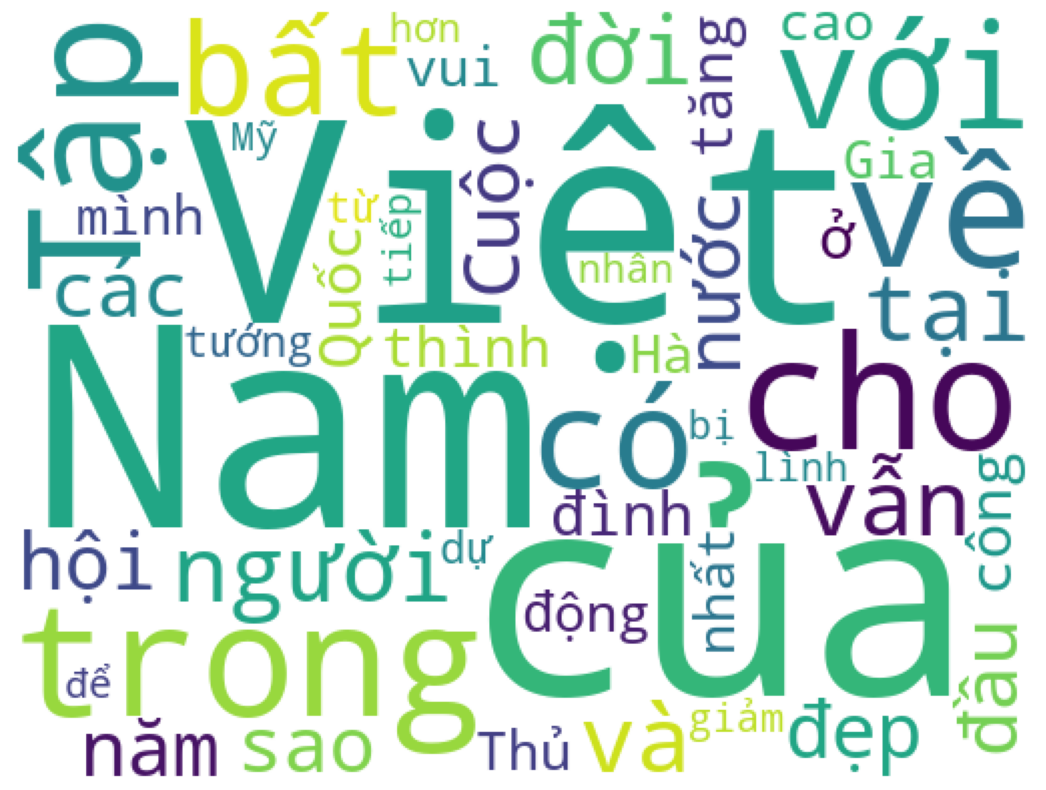

In [236]:

plt.subplots(figsize=(20, 10))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(top_word['Common_words']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('Plotly-World_Cloud.png')
plt.show()

## Cleaning and Processing data

In [237]:
def remove_stop_words(content):
    text = ' '.join(word for word in content.split() if word not in stop_words)
    return text

In [238]:
def removing_numbers(content):
    content = ''.join([i for i in content if not i.isdigit()])
    return content

In [239]:
def lower_case(content):
    content = content.split()
    content = [y.lower() for y in content]
    return " " .join(content)

In [240]:
def Removing_punctuations(content):
    ## Remove punctuations
    content = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', content)
    content = content.replace('؛',"", )
    
    ## remove extra whitespace
    content = re.sub('\s+', ' ', content)
    content =  " ".join(content.split())
    return content.strip()

In [241]:
def normalized_sentence(content):
    content = lower_case(content)
    content = Removing_punctuations(content)
    content = remove_stop_words(content)
    content = removing_numbers(content)
    return content

In [242]:
def normalize_text(df):
    df['Content'] = df['Content'].apply(lambda content : lower_case(content))
    df['Content'] = df['Content'].apply(lambda content : remove_stop_words(content))
    df['Content'] = df['Content'].apply(lambda content : Removing_punctuations(content))
    df['Content'] = df['Content'].apply(lambda content : removing_numbers(content))
    return df

In [243]:
df_small.head()

,Content,Topic
0,Quán triệt các quy định của Ban Bí thư về báo ...,chinh-tri
1,Phó Thủ tướng Trần Hồng Hà: Không để thiếu vac...,chinh-tri
2,ASEAN cần thích ứng năng động và tăng cường sứ...,chinh-tri
3,Tiếp tục hoàn thiện cơ chế xác định giá đất,chinh-tri
4,Bộ Công an trao tặng Giải thưởng Trần Quốc Hoà...,chinh-tri


In [244]:
df_big.head()

,Content,Topic
0,Thủ tướng Phạm Minh Chính tiếp xúc cử tri trướ...,chinh-tri
1,Thủ tướng bổ nhiệm lại Thứ trưởng Bộ Công Thương,chinh-tri
2,Thủ tướng Phạm Minh Chính dự khai mạc Lễ hội H...,chinh-tri
3,“Không có vướng mắc nào của địa phương không đ...,chinh-tri
4,"Dù ở vị trí nào mà có trách nhiệm, khát khao c...",chinh-tri


In [245]:
df_small = normalize_text(df_small)
df_big = normalize_text(df_big)

In [246]:
df_small.head()

,Content,Topic
0,quán triệt quy định ban bí thư báo chí xuất t...,chinh-tri
1,phó thủ tướng trần hồng hà vaccine tiêm chủng ...,chinh-tri
2,asean ứng năng động cường sức thân,chinh-tri
3,tiếp tục hoàn thiện chế xác định giá đất,chinh-tri
4,công an trao tặng giải thưởng trần quốc hoàn,chinh-tri


In [247]:
top = Counter([item for sublist in df_big['Content'].apply(lambda x:str(x).split()) for item in sublist])
print(len(top))
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

2025


,Common_words,count
0,nam,1064
1,việt,1027
2,tập,809
3,công,778
4,gia,761
5,đời,703
6,quốc,687
7,bất,677
8,hội,673
9,đình,598


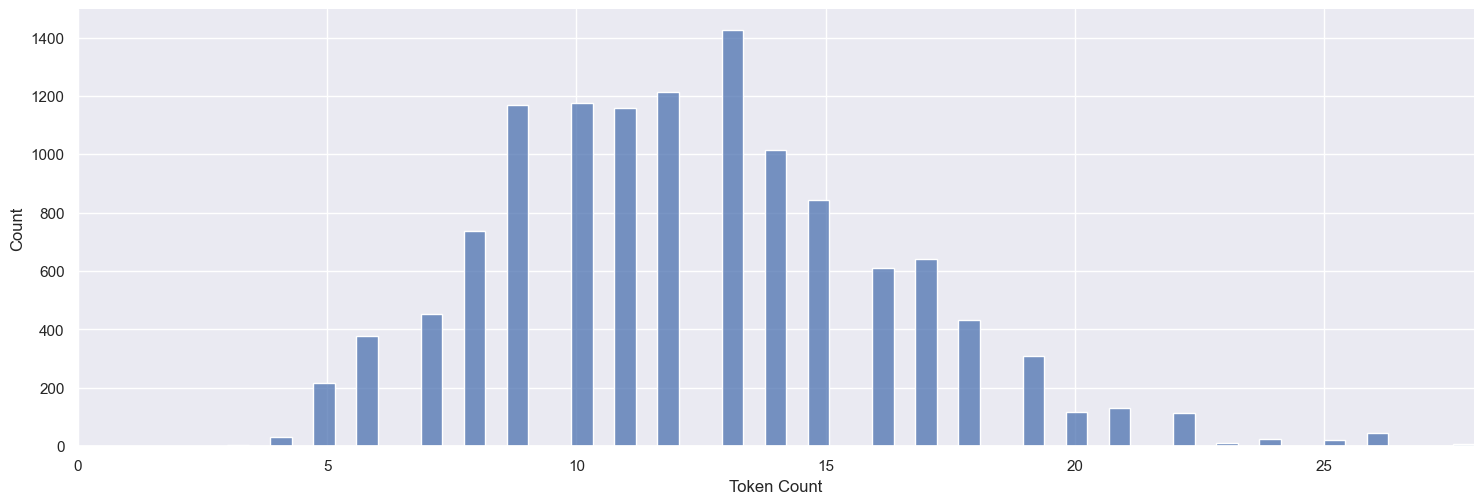

In [248]:
plot_count_token()

### Conclusion


## Extract feature -> endcode

In [249]:
model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [250]:
# Define a function to generate sentence embeddings
def generate_sentence_embedding(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Generate the embedding
    with torch.no_grad():
        outputs = model(input_ids)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    return embedding

In [251]:
def encode_lables(df):
    encode_lable.fit(df['Topic'])
    df['Topic'] = encode_lable.transform(df['Topic'])  

In [252]:
def embedding_sentences(df):
    df['Content_embedding'] = df['Content'].apply(lambda content : generate_sentence_embedding(content))

In [253]:
encode_lables(df_small)
embedding_sentences(df_small)
df_small.head()

,Content,Topic,Content_embedding
0,quán triệt quy định ban bí thư báo chí xuất t...,2,"[-0.11373056, 0.07864401, -0.27775264, -0.2287..."
1,phó thủ tướng trần hồng hà vaccine tiêm chủng ...,2,"[-0.13131015, 0.39955118, -0.03254381, -0.4663..."
2,asean ứng năng động cường sức thân,2,"[-0.022359889, 0.54952323, -0.47999114, 0.0947..."
3,tiếp tục hoàn thiện chế xác định giá đất,2,"[0.081581146, 0.36869, -0.036079563, -0.104082..."
4,công an trao tặng giải thưởng trần quốc hoàn,2,"[0.009790253, 0.3160427, -0.12560317, -0.01729..."


In [254]:
encode_lables(df_big)
embedding_sentences(df_big)
df_big.head()

,Content,Topic,Content_embedding
0,thủ tướng phạm minh tiếp xúc cử tri kỳ họp qu...,2,"[-0.50566494, 0.25212988, -0.10314354, -0.1241..."
1,thủ tướng bổ nhiệm trưởng công thương,2,"[-0.3327862, 0.39993358, -0.2807728, 0.0126368..."
2,thủ tướng phạm minh dự khai mạc lễ hội hoa phư...,2,"[-0.00094707776, 0.15248945, 0.0385617, -0.409..."
3,“không vướng mắc địa phương tập hợp giải đáp”,2,"[-0.11716218, 0.378845, -0.19078445, -0.327860..."
4,vị trí trách nhiệm khát khao cống hiến trở thà...,2,"[-0.09882682, 0.5554394, -0.16635859, -0.02844..."


In [255]:
df_small['Content_embedding'][1].shape

(768,)

In [256]:
def plot_content_3d(df):
    X = np.array(df['Content_embedding'].tolist())
    y = np.array(df['Topic'].tolist())

    # Sử dụng t-SNE để giảm chiều dữ liệu từ không gian đa chiều xuống không gian 3D
    tsne = TSNE(n_components=3)
    embeddings = tsne.fit_transform(X)

    # Tạo biểu đồ 3D và phân biệt các lớp
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Với mỗi lớp, tô màu các điểm tương ứng trên biểu đồ
    for label in np.unique(y):
        indices = np.where(y == label)
        ax.scatter(embeddings[indices, 0], embeddings[indices, 1], embeddings[indices, 2], label=label)

    # Thêm chú thích cho các lớp
    ax.legend()

    # Hiển thị biểu đồ
    plt.show()

In [257]:
def plot_content_2d(df):
    X = np.array(df['Content_embedding'].tolist())
    y = np.array(df['Topic'].tolist())

    # Sử dụng t-SNE để giảm chiều dữ liệu từ không gian đa chiều xuống không gian 2D
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(X)

    # Tạo biểu đồ 2D và phân biệt các lớp
    plt.figure(figsize=(20, 10))

    # Với mỗi lớp, tô màu các điểm tương ứng trên biểu đồ
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label)

    # Thêm chú thích cho các lớp
    plt.legend()

    # Hiển thị biểu đồ
    plt.show()

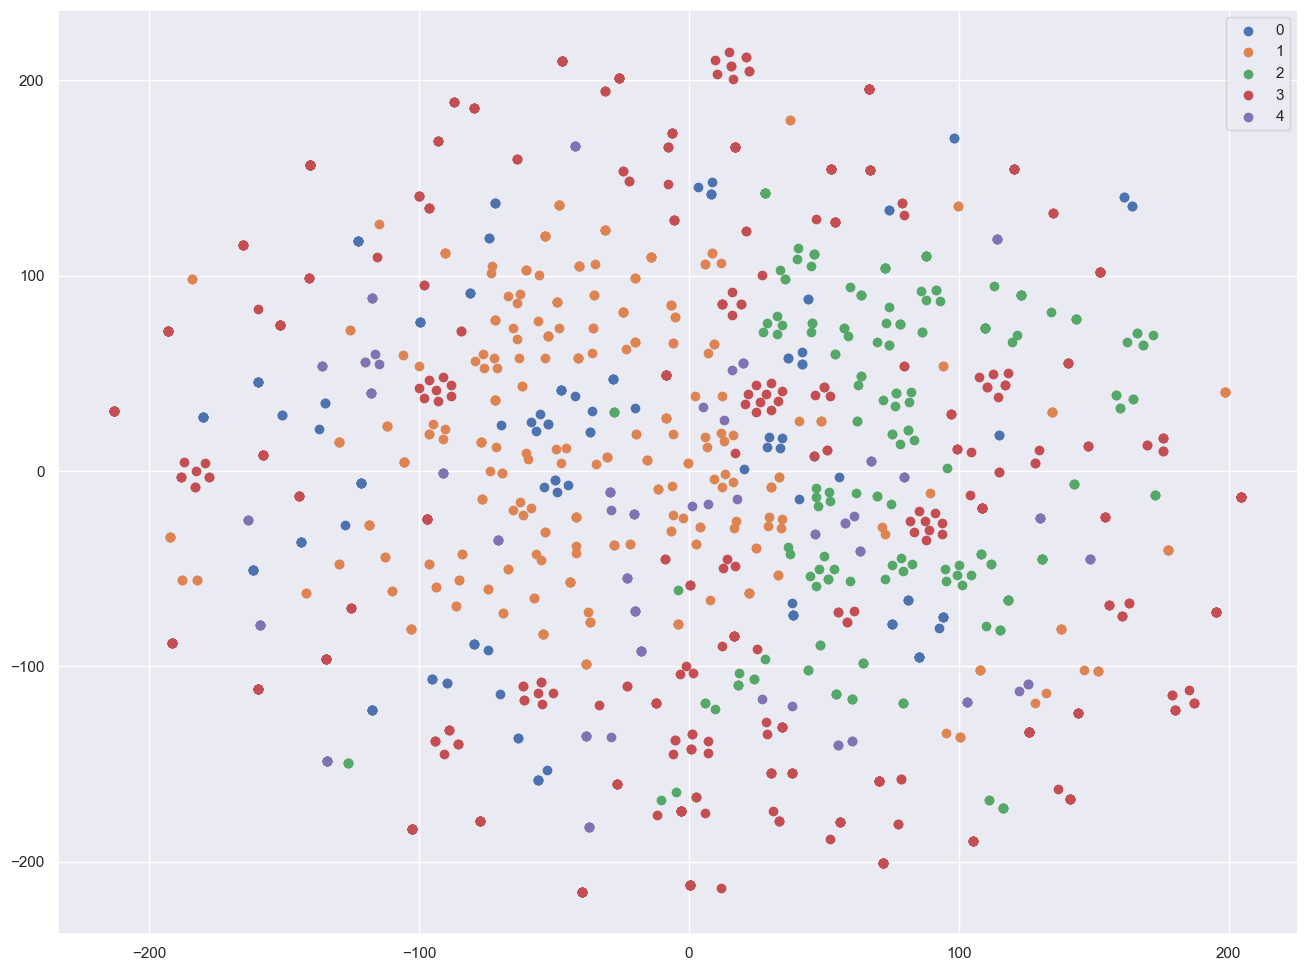

In [258]:
plot_content_2d(df_small)

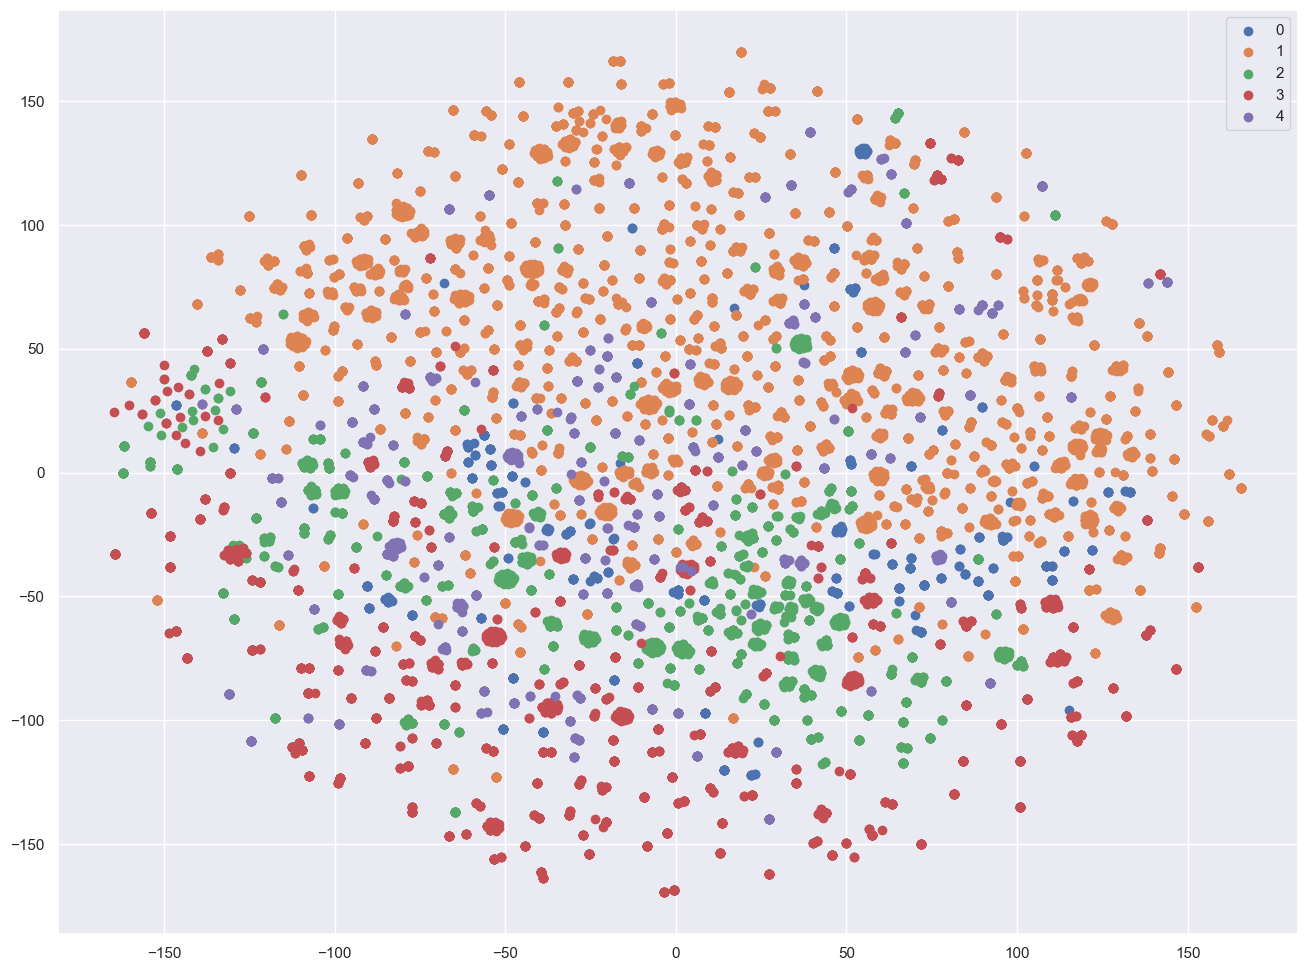

In [259]:
plot_content_2d(df_big)

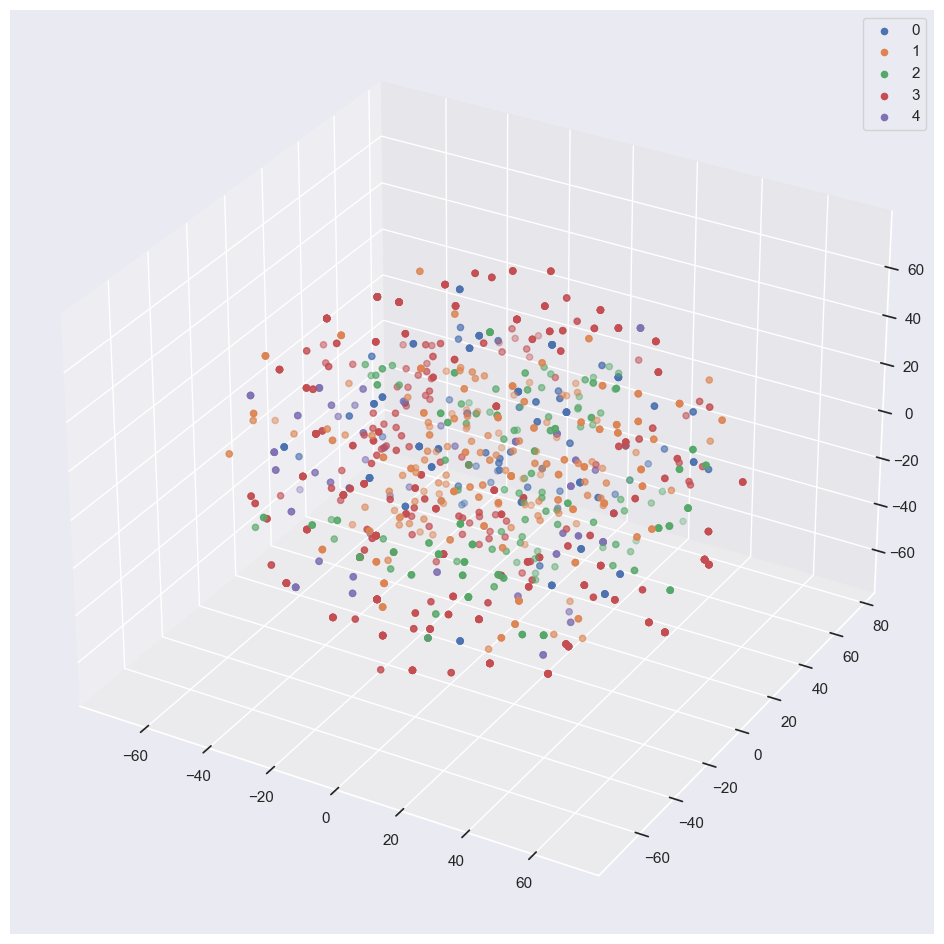

In [260]:
plot_content_3d(df_small)

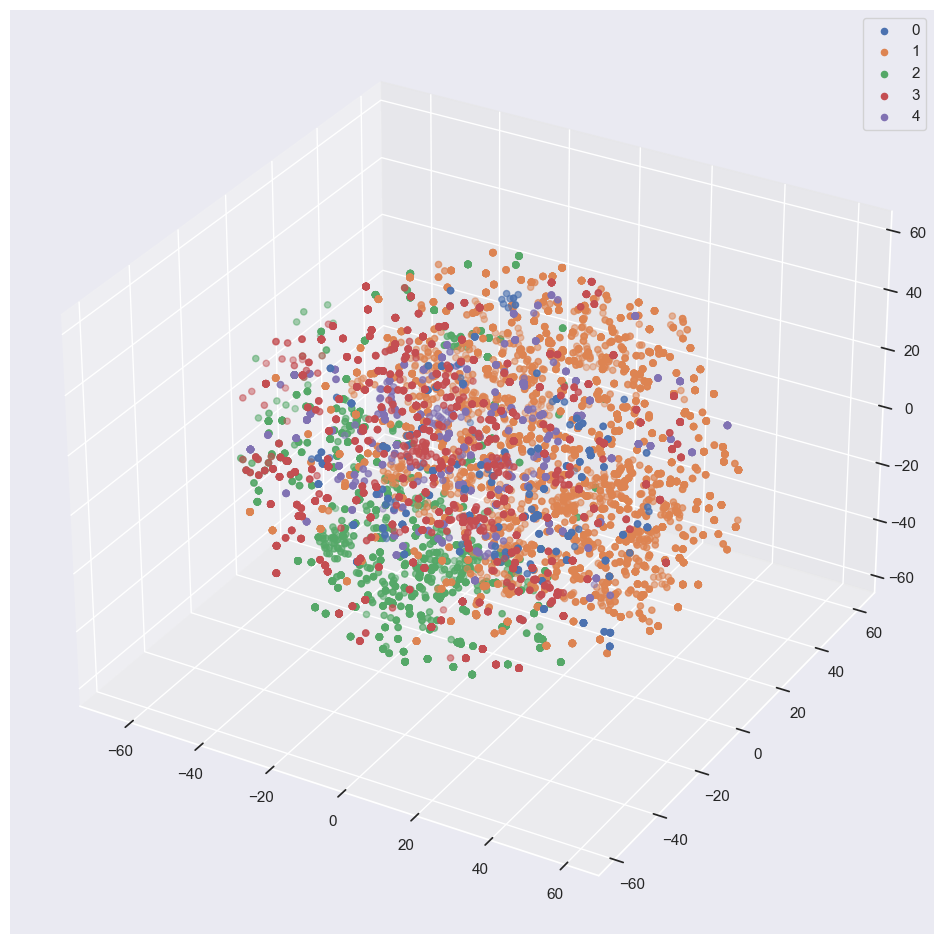

In [261]:
plot_content_3d(df_big)

## Modeling

In [262]:
def get_F1(trained_model,X,y):

    predicted = trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1 = f1_score(y, predicted, average=None)
    # Return the F1 score
    return f1

In [263]:
def eveluation_model(model, X_test, y_test):
    #test the model with the test data
    y_pred = model.predict(X_test)
    #calculate the accuracy
    log_reg_accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', log_reg_accuracy,'\n')

    #calculate the F1 score
    f1_Score = get_F1(model,X_test,y_test)
    return pd.DataFrame(f1_Score, index= df_small['Topic'].unique(), columns=['F1 score'])

In [264]:
def training_model(model, df):
    X = df["Content_embedding"].values
    X = np.vstack(X)
    y = df["Topic"].values
    X_train,X_test,y_train,y_test = train_test_split(X , y, test_size = 0.3, random_state = 6, stratify = y)
    # cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv =10).mean()
    model.fit(X_train, y_train)
    eveluation = eveluation_model(model, X_test ,y_test)
    return eveluation

In [265]:
training_model(SVC(kernel='linear', probability=True), df_small)

Accuracy:  0.9539951573849879 



,F1 score
2,0.857143
4,0.989899
3,0.929134
1,0.965714
0,0.955224


In [269]:
training_model(SVC(kernel='linear', probability=True), df_big)

Accuracy:  0.9804639804639804 



,F1 score
2,0.952681
4,0.995837
3,0.962433
1,0.971963
0,0.968491


In [267]:
training_model(RandomForestClassifier(n_estimators=100, random_state=42), df_small)

Accuracy:  0.9394673123486683 



,F1 score
2,0.794872
4,0.970297
3,0.913386
1,0.960452
0,0.953846


In [268]:
training_model(RandomForestClassifier(n_estimators=100, random_state=42), df_big)

Accuracy:  0.9764957264957265 



,F1 score
2,0.923077
4,0.989500
3,0.962433
1,0.968998
0,0.979730
